# Model training

### Read the Train Dataset

In [5]:
from azureml.core import Workspace, Dataset

workspace = Workspace.from_config()

dataset = Dataset.get_by_name(workspace, name='train-data')
train_data = dataset.to_pandas_dataframe().head()

### Load the Methods

In [6]:
import joblib
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

def load_data(train_data):
    # train_data = pd.read_csv(data_dir)
     # labels are in the first column
    train_y = train_data.iloc[:, 0].values
    train_X = train_data.iloc[:, 1:].values
    return train_y, train_X

def train_model(**args):
    kf = StratifiedKFold(n_splits=args['k_fold_splits'], shuffle=True, random_state=42)
    y,X = load_data(args['train'])
    cw = compute_class_weight('balanced', classes=np.unique(y), y=y)
    best = 0
    iteration = 0
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
       
        print("Training...")

        model = RandomForestClassifier(
            n_estimators=args['n_estimators'], verbose=args['verbose'], 
            n_jobs=-1, criterion='gini', max_leaf_nodes=args['max_leaf_nodes'], 
            max_depth=args['max_depth'], random_state=0, class_weight={0: cw[0], 1:cw[1]}
        )
        
        model.fit(X_train, y_train)
        print("Done! Computing scores...")        
        
        train_score = f1_score(y_train, model.predict(X_train))
        test_score = f1_score(y_test, model.predict(X_test))
        print("Iteration=%d; train_f1=%f; test_f1=%f;" % (iteration, train_score, test_score))
        
        if test_score > best:            
            best = test_score
            print("Saving checkpoint for best model: best_f1=%f;" % best)
            joblib.dump(model, os.path.join(args['output_data_dir'], "best_model.joblib"))
        
        iteration += 1
    print("\nSaving the best model: best_f1=%f;" % best)

### Train the Model

In [7]:
SM_MODEL_DIR = '../output-model'

# Hyperparameters are described here. In this simple example we are just including one hyperparameter.    
n_estimators = 30
max_depth = 10
max_leaf_nodes = -1
k_fold_splits = 2
verbose = 1

train_model(n_estimators=30, k_fold_splits=2, verbose=1, max_depth=10, max_leaf_nodes=-1, train=train_data, output_data_dir=SM_MODEL_DIR)

Training...
Done! Computing scores...
Iteration=0; train_f1=1.000000; test_f1=1.000000;
Saving checkpoint for best model: best_f1=1.000000;
Training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Done! Computing scores...
Iteration=1; train_f1=1.000000; test_f1=1.000000;

Saving the best model: best_f1=1.000000;


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


### Load model

In [8]:
model = joblib.load(SM_MODEL_DIR + '/best_model.joblib')

### Get features importance

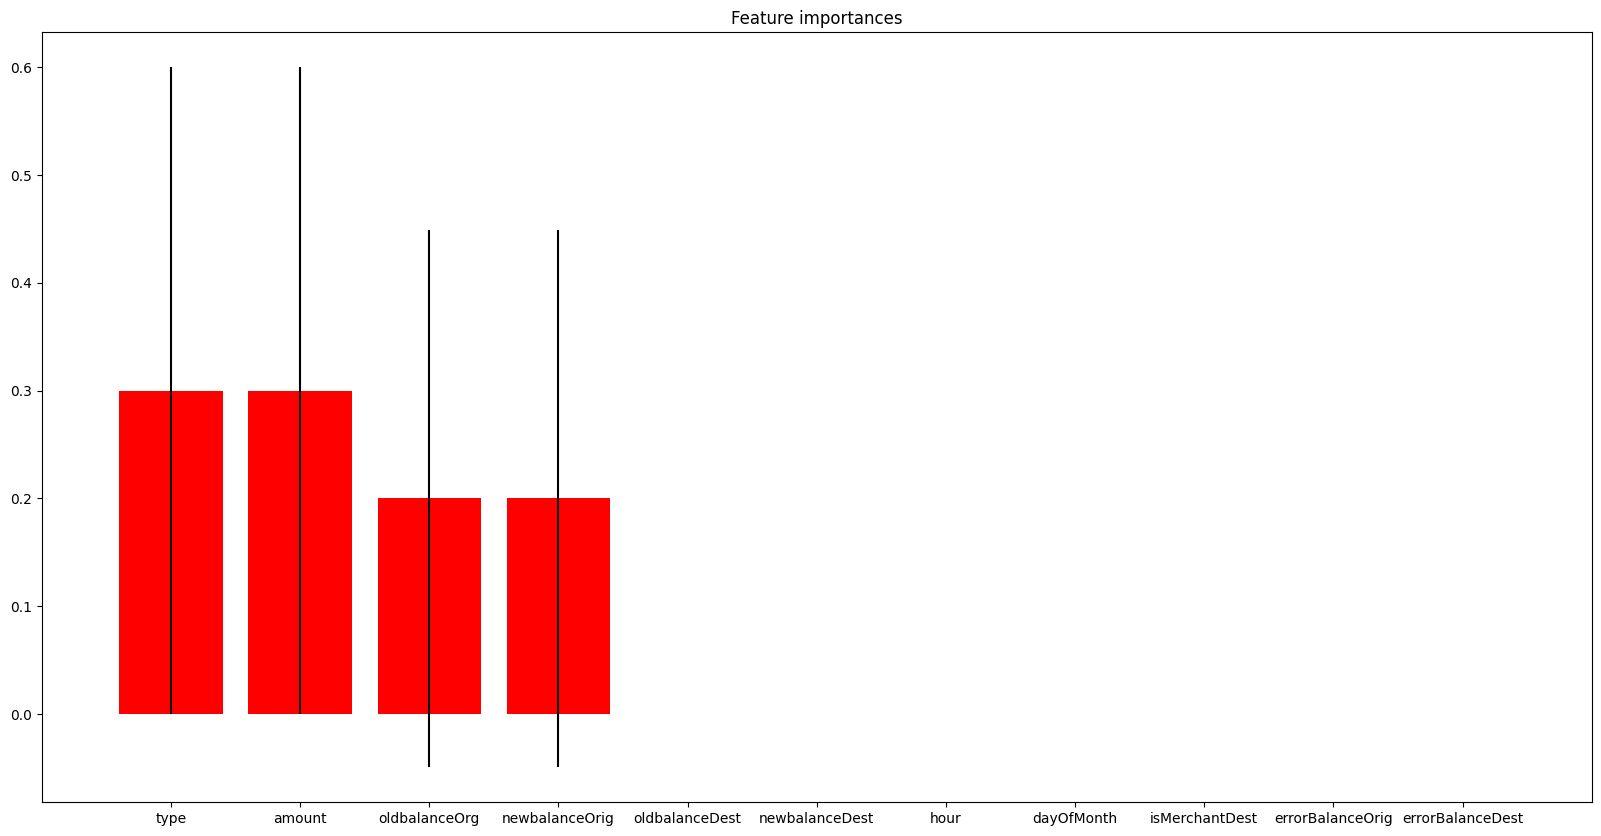

In [9]:
import matplotlib.pyplot as plt

importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
labels = np.array(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',    
    'newbalanceDest', 'hour', 'dayOfMonth', 'isMerchantDest',
        'errorBalanceOrig', 'errorBalanceDest'])

# Print the feature ranking
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(labels[indices], importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(indices, labels[indices])
plt.xlim([-1, len(indices)])
plt.show()

### Make Predictions

In [10]:
y,X = load_data(train_data)

In [11]:
%%time
import random

num_elements = 1
iterations = 1
correct_predictions = 1

for i in range(iterations):
  idx = random.randint(0, len(X)-num_elements)
  y_test, X_test = y[idx:idx+num_elements], X[idx:idx+num_elements]
  preds = model.predict(X_test)
  print(preds)
  correct_predictions += np.sum(np.equal(y_test, preds))

print("Correct Predictions: %d/%d" % (correct_predictions, iterations*num_elements ))

[0]
Correct Predictions: 2/1
CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 9.61 ms


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


### Register the Model

In [ ]:
from azureml.core.model import Model

Model.register(workspace, model_name="tessarato-fraud-model", model_path=SM_MODEL_DIR + '/best_model.joblib')
